# Behind the pipeline (PyTorch)

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

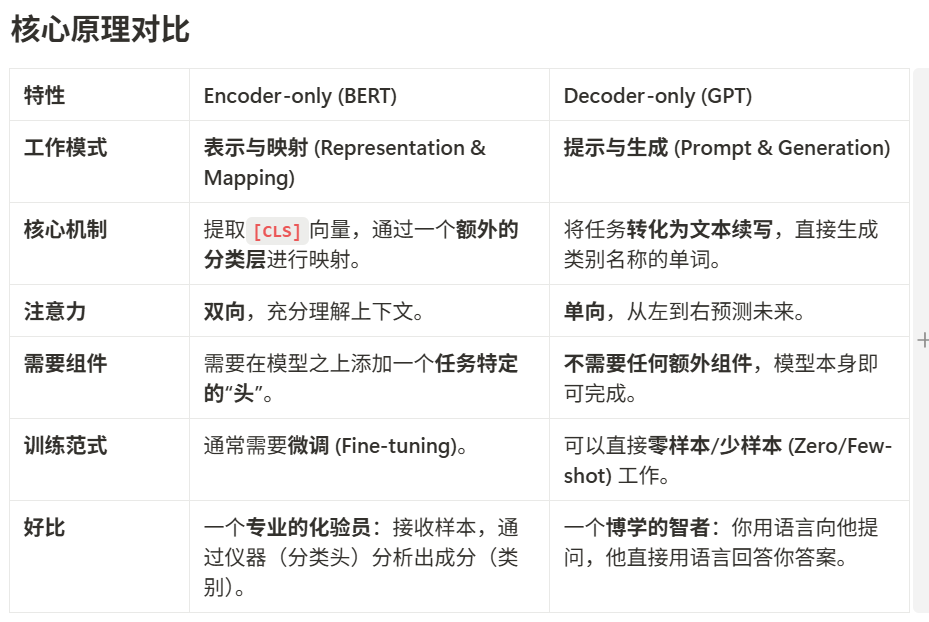

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]

In [1]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")
classifier(
    [
        "I've been waiting for a HuggingFace course my whole life.",
        "I hate this so much!",
    ]
)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cpu


[{'label': 'POSITIVE', 'score': 0.9598049521446228},
 {'label': 'NEGATIVE', 'score': 0.9994558691978455}]

In [2]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [3]:
raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")
print(inputs)

{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102],
        [  101,  1045,  5223,  2023,  2061,  2172,   999,   102,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])}


In [4]:
from transformers import AutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModel.from_pretrained(checkpoint)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

这个输出的隐藏状态是输入文本的丰富上下文表示。它本身不是一个分类结果，但非常有用。您可以将这些隐藏状态作为特征，输入到您自己定义的另一个分类器（比如一个简单的线性层）中，来进行下游任务的训练。它主要用于特征提取。This architecture contains only the base Transformer module: given some inputs, it outputs what we’ll call hidden states, also known as features. For each model input, we’ll retrieve a high-dimensional vector representing the contextual understanding of that input by the Transformer model.
此架构仅包含基本的 Transformer 模块：给定一些输入，它输出我们称之为 hidden state，也称为 features。对于每个模型输入，我们将检索一个高维向量，该向量表示 Transformer 模型对该输入的上下文理解 。

In [6]:
outputs = model(**inputs)
print(outputs.last_hidden_state.shape)

print(outputs)

torch.Size([2, 16, 768])
BaseModelOutput(last_hidden_state=tensor([[[-0.1798,  0.2333,  0.6321,  ..., -0.3017,  0.5008,  0.1481],
         [ 0.2758,  0.6497,  0.3200,  ..., -0.0760,  0.5136,  0.1329],
         [ 0.9046,  0.0985,  0.2950,  ...,  0.3352, -0.1407, -0.6464],
         ...,
         [ 0.1466,  0.5661,  0.3235,  ..., -0.3376,  0.5100, -0.0561],
         [ 0.7500,  0.0487,  0.1738,  ...,  0.4684,  0.0030, -0.6084],
         [ 0.0519,  0.3729,  0.5223,  ...,  0.3584,  0.6500, -0.3883]],

        [[-0.2937,  0.7283, -0.1497,  ..., -0.1187, -1.0227, -0.0422],
         [-0.2206,  0.9384, -0.0951,  ..., -0.3643, -0.6605,  0.2407],
         [-0.1536,  0.8988, -0.0728,  ..., -0.2189, -0.8528,  0.0710],
         ...,
         [-0.3017,  0.9002, -0.0200,  ..., -0.1082, -0.8412, -0.0861],
         [-0.3338,  0.9674, -0.0729,  ..., -0.1952, -0.8181, -0.0634],
         [-0.3454,  0.8824, -0.0426,  ..., -0.0993, -0.8329, -0.1065]]],
       grad_fn=<NativeLayerNormBackward0>), hidden_states

In [ ]:
from transformers import AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs)

AutoModelForSequenceClassification  这个类专门用于序列分类任务。当您使用它加载一个为序列分类微调过的模型时（比如您的 sst-2-english 模型），它不仅会加载模型的**“主体”，还会同时加载顶部的“分类头”**（classification head）。这个“头”通常是一个简单的全连接层（Linear Layer），它是在微调过程中训练好的，专门用来将模型的隐藏状态映射到最终的分类标签上。
当您将输入数据喂给这个模型时，它的输出不再是隐藏状态，而是logits。Logits 是模型对每个分类标签的原始、未经归一化的预测分数。您可以通过对 logits 应用 SoftMax 函数来得到每个分类的概率。
有什么用？ 这个类加载的模型是一个“端到端”的完整分类器，可以直接用来进行预测。

In [ ]:
print(outputs.logits.shape)

torch.Size([2, 2])

In [ ]:
print(outputs.logits)

tensor([[-1.5607,  1.6123],
        [ 4.1692, -3.3464]], grad_fn=<AddmmBackward>)

In [ ]:
import torch

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

tensor([[4.0195e-02, 9.5980e-01],
        [9.9946e-01, 5.4418e-04]], grad_fn=<SoftmaxBackward>)

In [ ]:
model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}

# 下面是优化后的脚本

In [14]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 1. 加载 Tokenizer (这部分和您原来的一样)
checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# 2. 准备输入数据 (也和原来一样)
raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")
print("Tokenized Inputs:")
print(inputs)
print("-" * 30)

# 3. 加载带有分类头的模型 (这是关键的改动)
# 注意：我们使用的是 AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

# 4. 进行预测
# 使用 with torch.no_grad() 是一个好习惯，因为我们只是在做推理，不需要计算梯度
with torch.no_grad():
    # 使用 **inputs 将字典解包成关键字参数，如 input_ids=..., attention_mask=...
    outputs = model(**inputs)

# 5. 解析输出
print("Model Outputs (Logits):")
logits = outputs.logits
print(logits)
print("-" * 30)

# 6. 将 logits 转换为可读的预测结果
# Logits 是原始分数，我们需要找到分数最高的那个类别的索引
predictions = torch.argmax(logits, dim=-1)
print("Predicted Class IDs:", predictions) # 输出 [1, 0]

# 7. 将预测的ID映射回标签名称
# 模型的配置中存储了 ID 和标签的对应关系
# predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
# print(predictions)
labels = [model.config.id2label[p.item()] for p in predictions]
print("Predicted Labels:", labels) # 输出 ['POSITIVE', 'NEGATIVE']

# 8. 将预测的结果加上概率
probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(probabilities)
results = []
for p, probs in zip(predictions, probabilities):
    # p.item() gets the integer value of the prediction (e.g., 1)
    # probs.max().item() gets the float value of the highest probability
    label = model.config.id2label[p.item()]
    score = probs.max().item()
    results.append({
        'label': label,
        'score': score
    })

print("Predicted Labels with Scores:")
print(results)

Tokenized Inputs:
{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102],
        [  101,  1045,  5223,  2023,  2061,  2172,   999,   102,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])}
------------------------------
Model Outputs (Logits):
tensor([[-1.5607,  1.6123],
        [ 4.1692, -3.3464]])
------------------------------
Predicted Class IDs: tensor([1, 0])
Predicted Labels: ['POSITIVE', 'NEGATIVE']
tensor([[4.0195e-02, 9.5980e-01],
        [9.9946e-01, 5.4418e-04]])
Predicted Labels with Scores:
[{'label': 'POSITIVE', 'score': 0.9598049521446228}, {'label': 'NEGATIVE', 'score': 0.9994558691978455}]


In [28]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

encoded_input = tokenizer(["Hello, I'm a single sentence!","You're so good!"], padding=True)

# encoded_input = tokenizer(
#     ["How are you?", "I'm fine, thank you!"], padding=True, return_tensors="pt")
print(encoded_input)

tokenizer.decode(encoded_input["input_ids"][1])

{'input_ids': [[101, 8667, 117, 146, 112, 182, 170, 1423, 5650, 106, 102], [101, 1192, 112, 1231, 1177, 1363, 106, 102, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]]}


"[CLS] You ' re so good! [SEP] [PAD] [PAD] [PAD]"

In [ ]:
from transformers import AutoTokenizer
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

encoded_input = tokenizer(["Hello, I'm a single sentence!","You're so good!"], padding=True, return_tensors="pt")


model_inputs = torch.tensor(encoded_input)


# 现在我们来检查 model_inputs
print(type(encoded_input))
print(encoded_input)